In [2]:
import io
import itertools
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
import numpy as np
import os
from xml.etree import ElementTree
from PIL import Image, ImageDraw

In [3]:
import math
from torch import default_generator, randperm
from torch._utils import _accumulate
from torch.utils.data.dataset import Subset

def random_split(dataset, lengths,
                 generator=default_generator):
    r"""
    Randomly split a dataset into non-overlapping new datasets of given lengths.

    If a list of fractions that sum up to 1 is given,
    the lengths will be computed automatically as
    floor(frac * len(dataset)) for each fraction provided.

    After computing the lengths, if there are any remainders, 1 count will be
    distributed in round-robin fashion to the lengths
    until there are no remainders left.

    Optionally fix the generator for reproducible results, e.g.:

    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    >>> random_split(range(30), [0.3, 0.3, 0.4], generator=torch.Generator(
    ...   ).manual_seed(42))

    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths or fractions of splits to be produced
        generator (Generator): Generator used for the random permutation.
    """
    if math.isclose(sum(lengths), 1) and sum(lengths) <= 1:
        subset_lengths: List[int] = []
        for i, frac in enumerate(lengths):
            if frac < 0 or frac > 1:
                raise ValueError(f"Fraction at index {i} is not between 0 and 1")
            n_items_in_split = int(
                math.floor(len(dataset) * frac)  # type: ignore[arg-type]
            )
            subset_lengths.append(n_items_in_split)
        remainder = len(dataset) - sum(subset_lengths)  # type: ignore[arg-type]
        # add 1 to all the lengths in round-robin fashion until the remainder is 0
        for i in range(remainder):
            idx_to_add_at = i % len(subset_lengths)
            subset_lengths[idx_to_add_at] += 1
        lengths = subset_lengths
        for i, length in enumerate(lengths):
            if length == 0:
                warnings.warn(f"Length of split at index {i} is 0. "
                              f"This might result in an empty dataset.")

    # Cannot verify that dataset is Sized
    if sum(lengths) != len(dataset):    # type: ignore[arg-type]
        raise ValueError("Sum of input lengths does not equal the length of the input dataset!")

    indices = randperm(sum(lengths), generator=generator).tolist()  # type: ignore[call-overload]
    return [Subset(dataset, indices[offset - length : offset]) for offset, length in zip(_accumulate(lengths), lengths)]

In [4]:
class MislabeledError(RuntimeError):
    def __init__(self):
        return

UNLABELED_ERROR_THRESHOLD=1000

class PKWholeDataset:
  def __init__(self, root, transform = None):
    self.images = []
    self.labels = []
    self.image_metadata = []
    self.transform = transform
    if isinstance(root, str):
        for filename in os.scandir(root):
            #Ignore top level files
            if filename.is_dir():
                self.load_dir(filename)
    elif isinstance(root, list):
        for path in root:
            for filename in os.scandir(path):
                #Ignore top level files
                if filename.is_dir():
                    self.load_dir(filename)

  def load_dir(self, directory: os.DirEntry):
    for entry in os.scandir(directory):
      if entry.is_file():
        if entry.name.endswith('.jpg'):
          #Labels are the directory names, except for the file name
          labels: [str] = entry.path.split(os.sep)
          #Filename
          labels.pop(-1)
          #Misc directories that aren't labels
          not_labels = ["PKLot", "PkLot", ".", "PKLotSegmented"]
          for not_label in not_labels:
            try:
              labels.remove(not_label)
            except ValueError:
              continue
          labels = list(set(labels))
          self.images.append(entry)
          self.labels.append(labels)
          metadata_file = entry.path.replace(".jpg", ".xml")
          self.image_metadata.append(metadata_file)
          # just make sure that the labels and entries match up
          assert len(self.images) == len(self.labels)
      elif entry.is_dir():
        self.load_dir(entry)

  def __len__(self):
    return len(self.images)

  #Loads images from FS rather than from memory
  def __getitem__(self, index):
    file = open(self.images[index].path, mode='rb')
    image = Image.open(io.BytesIO(file.read()))
    if self.transform is not None:
      image = self.transform(image)
    label = self.get_label(index)
    return image, label

  def get_image(self, index):
      file = open(self.images[index].path, mode='rb')
      image = Image.open(io.BytesIO(file.read()))
      return image

  def get_label(self, index):
    doc = ElementTree.parse(self.get_metadata(index))
    empty = 0
    unlabeled_count = 0
    for space in doc.getroot().findall('space'):
        if space.get('occupied') is None:
            unlabeled_count = unlabeled_count + 1
            continue
        if int(space.get('occupied')) == 0:
            empty += 1
    if unlabeled_count > UNLABELED_ERROR_THRESHOLD:
        raise MislabeledError
    return empty

  def get_metadata(self, index):
    return self.image_metadata[index]

In [5]:
class PKSegmentedDataset:
    def __init__(self, root, transform = None):
        self.images = []
        self.labels = []
        self.transform = transform
        if isinstance(root, str):
            for filename in os.scandir(root):
                #Ignore top level files
                if filename.is_dir():
                    self.load_dir(filename)
        elif isinstance(root, list):
            for path in root:
                for filename in os.scandir(path):
                    #Ignore top level files
                    if filename.is_dir():
                        self.load_dir(filename)

    def load_dir(self, directory: os.DirEntry):
        for entry in os.scandir(directory):
            if entry.is_file():
                if entry.name.endswith('.jpg'):
                    #Labels are the directory names, except for the file name
                    labels: [str] = entry.path.split(os.sep)
                    #Filename
                    labels.pop(-1)
                    #Misc directories that aren't labels
                    not_labels = ["PKLot", "PkLot", ".", "PKLotSegmented"]
                    for not_label in not_labels:
                        try:
                            labels.remove(not_label)
                        except ValueError:
                            continue
                    labels = list(set(labels))
                    self.images.append(entry)
                    self.labels.append(labels)
                    # just make sure that the labels and entries match up
                    assert len(self.images) == len(self.labels)
            elif entry.is_dir():
                self.load_dir(entry)

    def __len__(self):
        return len(self.images)

    #Loads images from FS rather than from memory
    def __getitem__(self, index):
        file = open(self.images[index].path, mode='rb')
        image = Image.open(io.BytesIO(file.read()))
        if self.transform is not None:
            image = self.transform(image)
        label = self.get_label(index)
        return image, label

    def get_image(self, index):
        file = open(self.images[index].path, mode='rb')
        image = Image.open(io.BytesIO(file.read()))
        return image

    def get_label(self, index):
        #For segmented image, label is 1 if the space is occupied, 0 if unoccupied
        label = 0
        if "Occupied" in self.labels[index]:
            label = 1
        return label

In [6]:
batch_size=1

whole_transform = T.Compose([T.Resize((720, 1280)), T.ToTensor(), T.Normalize([0, 0, 0], [1, 1, 1])])
segmented_transform = T.Compose([T.Resize((48, 64)), T.ToTensor(), T.Normalize([0, 0, 0], [1, 1, 1])])

pk_whole_dataset = PKWholeDataset('./PKLot/PKLot', whole_transform)
pk_segmented_dataset = PKSegmentedDataset(['./PKLot/PKLotSegmented'], segmented_transform)

pk_seg_test_dataset, pk_seg_train_dataset = random_split(pk_segmented_dataset, [0.2, 0.8], generator=torch.Generator().manual_seed(42))

pk_whole_loader = torch.utils.data.DataLoader(pk_whole_dataset, batch_size=batch_size, pin_memory=True)
pk_segmented_test_loader = torch.utils.data.DataLoader(pk_seg_test_dataset, batch_size=batch_size, pin_memory=True)
pk_segmented_train_loader = torch.utils.data.DataLoader(pk_seg_train_dataset, batch_size=batch_size, pin_memory=True)

In [7]:
def metadata_to_rectangle(space):
    rect = space.find('rotatedRect')
    center = rect.find('center')
    size = rect.find('size')
    angle = rect.find('angle')
    bottom_left_x = int(center.get("x")) - (int(size.get("w")) / 2)
    bottom_left_y = int(center.get("y")) - (int(size.get("h")) / 2)
    if int(space.get("occupied")) >= 1:
        color="red"
    else:
        color="blue"
    return patches.Rectangle(xy=(bottom_left_x, bottom_left_y),
                      width=int(size.get("w")),
                      height=int(size.get("h")),
                      angle=float(angle.get("d")),
                      rotation_point="center",
                      color=color,
                      fill=False)

def plot_image(ax, dataset, idx = 0):
    plt.xticks([])
    plt.yticks([])
    ax.imshow(dataset.get_image(idx))
    doc = ElementTree.parse(dataset.get_metadata(idx))
    doc.getroot().items()[0]
    for space in doc.getroot().iter('space'):
        ax.add_patch(metadata_to_rectangle(space))

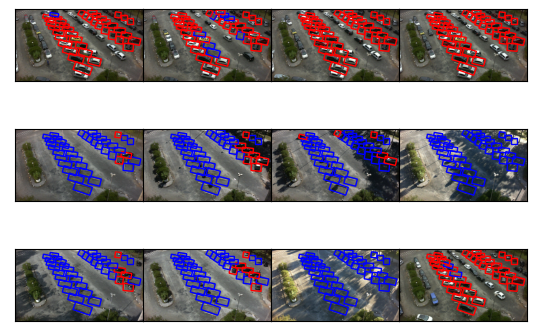

In [8]:
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
  for j in range(0, ncol):
    ax = plt.subplot(gs[i, j])
    plot_image(ax, pk_whole_dataset, ((i*ncol)+j)*20)
plt.show()

0; 1
1; 1
2; 1
3; 1
4; 1
5; 0
6; 1
7; 1
8; 0
9; 0
10; 0
11; 0


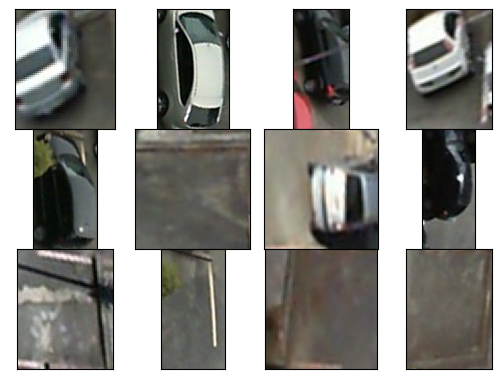

torch.Size([3, 48, 64])


In [9]:
nrow = 3
ncol = 4
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))
for i in range(0, nrow):
    for j in range(0, ncol):
        ax = plt.subplot(gs[i, j])
        plt.xticks([])
        plt.yticks([])
        ax.imshow(pk_segmented_dataset.get_image((i * ncol + j) * 500))
        occupied = pk_segmented_dataset.get_label((i*ncol + j) * 500)
        print(f"{(i*ncol + j)}; {occupied}".format())
plt.show()
print(pk_seg_train_dataset[0][0].size())

In [10]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn1 = nn.BatchNorm2d(10)
        #ReLU
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn2 = nn.BatchNorm2d(20)
        #ReLU
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, stride=1, padding=2, padding_mode="zeros")
        self.bn3 = nn.BatchNorm2d(30)
        #ReLU
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(30*24*32*batch_size, 20)
        #ReLU
        self.linear2 = nn.Linear(20, 10)
        #ReLU
        self.linear3 = nn.Linear(10, 2)
        #ReLU
        self.soft_max = nn.Softmax(dim=1)

    def forward(self, input):
        output = F.relu(self.bn1(self.conv1(input)))
        output = F.relu(self.bn2(self.conv2(output)))
        output = self.pool(F.relu(self.bn3(self.conv3(output))))
        output = self.flatten(output)
        output = F.relu(self.linear1(output))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = self.soft_max(output)
        return output.float()

model = Network()

In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()
        # Compute prediction and loss
        pred = model(X)
        pred.cuda()
        loss = loss_fn(pred, y)
        loss.cuda()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return current


def test_loop(dataloader, model, loss_fn, results):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            if torch.cuda.is_available():
                 X = X.cuda()
                 y = y.cuda()
            pred = model(X)
            if torch.cuda.is_available():
                pred.cuda()
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    results["accuracy"] = correct
    results["loss"] = test_loss
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [12]:
occupied = 0
empty = 0
#Set TEST to true to trest already built models in addition to unbuild models
TEST = True
#Get the count of labels in each training set
if TEST:
    for label in pk_seg_train_dataset:
        if label[1] == 1:
            occupied = occupied + 1
        else:
            empty = empty + 1
    print(f"{empty};{occupied}")
    sum = empty+occupied
else:
    sum, empty, occupied = 2, 1, 1
tensor = torch.tensor([empty/sum, occupied/sum], dtype=torch.float)

In [13]:
tensor.cuda()
print(torch.cuda.is_available())
loss_fn = nn.CrossEntropyLoss(weight=tensor)
loss_fn.cuda()

True


CrossEntropyLoss()

In [14]:
if torch.cuda.is_available():
    model.to("cuda")
    torch.backends.cudnn.enabled = False

epochs=15
learning_rates = [1e-7, 1e-5, 1e-3]
results = {}
for rate in learning_rates:
    try:
        os.mkdir('./models/' + str(rate) + '/')
    except:
        pass
        #do nothing
    results[rate] = {}
    if not rate == 1e-7:
        epochs = 5
    else:
        epochs = 15
    for t in range(epochs):
        file = './models/' + str(rate) + '/Model_Epoch_' + str(t) + '.pt'
        loaded = False
        try:
            loaded_data = torch.load(file)
            loaded = True
            model.load_state_dict(loaded_data["model_state_dict"])
            #Make sure the learning rate is correct
            loaded_data["optimizer_state_dict"]["param_groups"][0]["lr"] = rate
            optimizer.load_state_dict(loaded_data["optimizer_state_dict"])
            print("Model loaded")
        except Exception as e:
            print("Error loading model: " + str(e))
            model.cuda()
            optimizer = torch.optim.Adam(model.parameters(), lr=rate)

        results[rate][t] = {}
        if not loaded:
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(pk_segmented_train_loader, model, loss_fn, optimizer)
            torch.save({
                'epoch': t,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, file)
        if TEST:
            test_loop(pk_segmented_test_loader, model, loss_fn, results[rate][t])

print("Done!")
print(results)

Error loading model: name 'optimizer' is not defined
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Model loaded
Done!
{1e-07: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}, 7: {}, 8: {}, 9: {}, 10: {}, 11: {}, 12: {}, 13: {}, 14: {}}, 1e-05: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}, 0.001: {0: {}, 1: {}, 2: {}, 3: {}, 4: {}}}


In [15]:
# define a cross validation function
def crossvalid(dataset=None,k_fold=5):
    import pandas as pd
    import random
    train_score = pd.Series()
    val_score = pd.Series()

    total_size = len(dataset)
    fraction = 1/k_fold
    seg = int(total_size * fraction)
    shuffled = list(range(total_size))
    random.shuffle(shuffled)
    for i in range(k_fold):
        trll = 0
        trlr = i * seg
        vall = trlr
        valr = i * seg + seg
        trrl = valr
        trrr = total_size

        train_left_indices = list(range(trll,trlr))
        train_right_indices = list(range(trrl,trrr))

        train_indices = []

        if train_left_indices is not None:
            train_indices = train_indices + [shuffled[i] for i in train_left_indices]
        if train_right_indices is not None:
            train_indices = train_indices + [shuffled[i] for i in train_right_indices]
        val_indices = shuffled[vall:valr]

        train_set = torch.utils.data.dataset.Subset(dataset,train_indices)
        val_set = torch.utils.data.dataset.Subset(dataset,val_indices)

        train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, pin_memory=True)
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, pin_memory=True)
        res_model = Network()
        res_model.cuda()
        optimizer = torch.optim.Adam(res_model.parameters(), lr=1e-5)
        loss_fn = nn.CrossEntropyLoss()
        loss_fn.cuda()
        #Number of epochs to run training before validating
        for epoch in range(3):
            train_acc = train_loop(train_loader, res_model,loss_fn,optimizer)
            train_score.at[i] = train_acc
            print(f"{i}; Epoch: {epoch} Train Score: {train_acc}")
        val_acc = test_loop(val_loader,res_model,loss_fn, {})
        val_score.at[i] = val_acc
        print(f"{i}; Test Score: {val_acc}")
    return train_score,val_score
#Uncomment this code to run cross validation on a model
# train_score,val_score = crossvalid(dataset=pk_segmented_dataset)
# print(f"{train_score};{val_score}")

In [16]:
#Best model
file = './models/' + str(1e-5) + '/Model_Epoch_' + str(2) + '.pt'
loaded_data = torch.load(file)
model.load_state_dict(loaded_data["model_state_dict"])
optimizer.load_state_dict(loaded_data["optimizer_state_dict"])

pucpr_dataset = PKWholeDataset('./PKLot/PKLot/PUCPR', whole_transform)
ufpr04_dataset = PKWholeDataset('./PKLot/PKLot/UFPR04', whole_transform)
ufpr05_dataset = PKWholeDataset('./PKLot/PKLot/UFPR05', whole_transform)

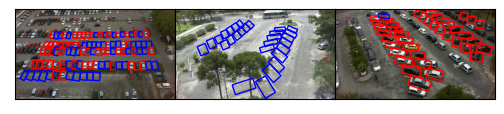

In [17]:
nrow = 1
ncol = 3
gs = gridspec.GridSpec(nrow, ncol,
                       wspace=0.0, hspace=0.0,
                       top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1),
                       left=0.5/(ncol+1), right=1-0.5/(ncol+1))



plot_image(plt.subplot(gs[0,0]), pucpr_dataset)
plot_image(plt.subplot(gs[0,1]), ufpr04_dataset)
plot_image(plt.subplot(gs[0,2]), ufpr05_dataset)
plt.show()

In [42]:
from matplotlib.patches import Rectangle

#Gets a rectangular bounding box given a set of points
def bbox(points):
    x_coordinates, y_coordinates = zip(*points)
    return [(min(x_coordinates), min(y_coordinates)), (max(x_coordinates), max(y_coordinates))]

#Given a tensor and bounding box, extract the array contained in the bounding box, rotated and resized
def extract_image(tensor_in, patch: Rectangle):
    #get corners and bounding box of tensor
    corners = patch.get_corners()
    bbox_results = bbox(corners)

    #Crop by bounding box,
    new_image = tensor_in[:, int(bbox_results[0][1]):int(bbox_results[1][1]), int(bbox_results[0][0]):int(bbox_results[1][0])]
    #Rotate
    new_image = torchvision.transforms.functional.rotate(new_image, patch.get_angle())
    #Crop by rectangle patch
    full_rows = np.bitwise_or.reduce(np.all(np.array(new_image), axis=2, keepdims=1)).flatten()
    full_columns = np.bitwise_or.reduce(np.all(np.array(new_image), axis=1, keepdims=1)).flatten()
    if np.any(full_rows):
        new_image = new_image[:, full_rows, :]
    else:
        new_image = new_image[:, :, full_columns]
    #Resize
    new_image = torchvision.transforms.Resize((48, 64))(new_image)
    #Uncomment to show image for debugging
    #plt.imshow(T.ToPILImage()(new_image))
    return new_image

In [43]:
#This section runs the model on a dataset and collects the accuracy
#I probably wouldn't mess with this until you are comfortable with the above
# total=0
# correct=0
# mse = 0
# dataset = pucpr_dataset
# length = len(dataset)
# full_run_results = []
# for i in range(len(dataset)):
#     meta = dataset.get_metadata(i)
#     try:
#         whole_image = dataset[i][0]
#         labeled_empty = dataset[i][1]
#     except MislabeledError:
#         print("Mislabeled xml")
#         continue
#     doc = ElementTree.parse(meta)
#     spaces = doc.getroot().findall('space')
#     estimated_occupied = 0
#     estimated_empty = 0
#     for space in spaces:
#         try:
#             label = True if int(space.get('occupied')) == 1 else False
#         except TypeError:
#             continue
#         rect = metadata_to_rectangle(space)
#         segmented_image = extract_image(whole_image, rect)
#         #Expand to add batch dimension
#         segmented_image = segmented_image[None, :, :, :]
#         segmented_image = segmented_image.cuda()
#         result = model(segmented_image)
#         if result[0][0].item() > result[0][1].item():
#             occupied = False
#             estimated_empty = estimated_empty + 1
#         else:
#             occupied = True
#             estimated_occupied = estimated_occupied + 1
#         total = total + 1
#         if occupied == label:
#             correct = correct + 1
#     full_run_results.append((labeled_empty, estimated_empty, estimated_occupied))
#     mse = mse + math.pow(estimated_empty - labeled_empty, 2)
#     if i % 100 == 0:
#         print(f"Progress: [{i}/{length}]\nAccuracy: [{correct*100/total:.2f}%]\nMSE: [{mse/(1 if i == 0 else i):.5f}]")
# print("Done")
# print(f"Accuracy: {(correct/total)*100:.2f}\nMSE: {mse/length}")

Progress: [0/4219]
Accuracy: [97.00%]
MSE: [1.00000]


KeyboardInterrupt: 